## This example shows some utilties for post-processing head results from MODFLOW

In [1]:
import sys
sys.path.append('/Users/aleaf/Documents/GitHub/flopy3')
import numpy as np
import matplotlib.pyplot as plt
import flopy
from flopy.utils.postprocessing import get_transmissivities, get_water_table, get_gradients, get_saturated_thickness
import flopy.utils.binaryfile as bf

%matplotlib inline
fm = flopy.modflow

In [2]:
mfnam = 'EXAMPLE.nam'
model_ws = '../data/mp6/'
heads_file = 'EXAMPLE.HED'

### Load example model and head results

In [3]:
m = fm.Modflow.load(mfnam, model_ws=model_ws)

In [4]:
hdsobj = bf.HeadFile(model_ws+heads_file)
hds = hdsobj.get_data(kstpkper=(0, 2))
hds.shape

(5, 25, 25)

### Plot heads in each layer; export the heads and head contours for viewing in a GIS
for more information about GIS export, type `help(export_array)`, for example

wrote temp/heads1.tif
wrote temp/heads1.shp
wrote temp/heads2.tif
wrote temp/heads2.shp
wrote temp/heads3.tif
wrote temp/heads3.shp
wrote temp/heads4.tif
wrote temp/heads4.shp
wrote temp/heads5.tif
wrote temp/heads5.shp


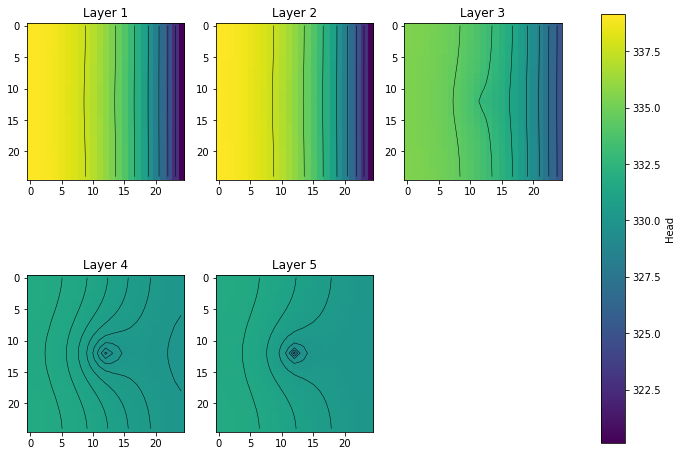

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(11, 8.5))
axes = axes.flat
for i, hdslayer in enumerate(hds):
    im = axes[i].imshow(hdslayer, vmin=hds.min(), vmax=hds.max())
    axes[i].set_title('Layer {}'.format(i+1))
    ctr = axes[i].contour(hdslayer, colors='k', linewidths=0.5)
    
    # export head rasters 
    # (GeoTiff export requires the rasterio package; for ascii grids, just change the extention to *.asc)
    m.sr.export_array('temp/heads{}.tif'.format(i+1), hdslayer)
    
    # export head contours to a shapefile
    m.sr.export_array_contours('temp/heads{}.shp'.format(i+1), hdslayer)
    
fig.delaxes(axes[-1])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Head')

### Compare rotated arc-ascii and GeoTiff output

wrote temp/heads5_rot.asc
wrote temp/heads5_rot.tif


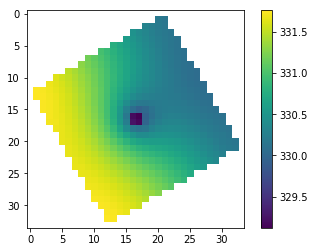

In [6]:
m.sr.rotation = 30.
nodata = 0.
m.sr.export_array('temp/heads5_rot.asc', hdslayer, nodata=nodata)
m.sr.export_array('temp/heads5_rot.tif', hdslayer, nodata=nodata)

results = np.loadtxt('temp/heads5_rot.asc'.format(i+1), skiprows=6)
results[results == nodata] = np.nan
plt.imshow(results)
plt.colorbar()
results.shape

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 25, 'height': 25, 'count': 1, 'crs': None, 'transform': Affine(105.58581722939877, 60.959999999999994, 0.0,
       60.959999999999994, -105.58581722939877, 10000.0)}


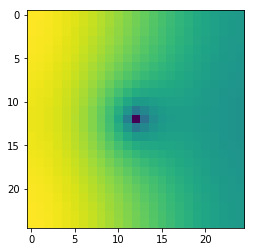

In [7]:
import rasterio
with rasterio.open('temp/heads5_rot.tif'.format(i+1)) as src:
    print(src.meta)
    plt.imshow(src.read(1))

### Get the vertical head gradients between layers

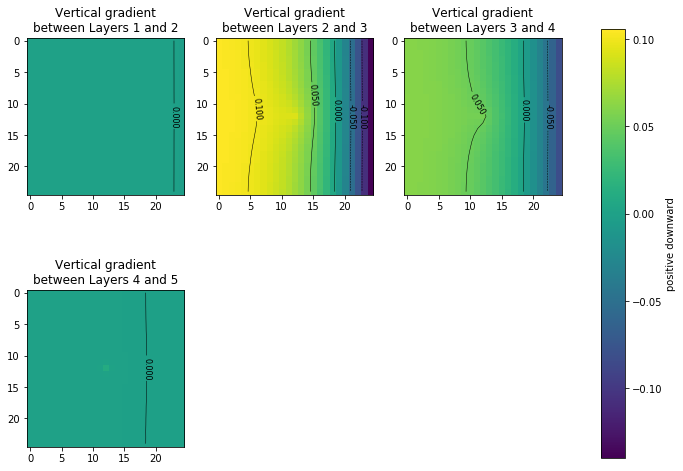

In [8]:
grad = get_gradients(hds, m, nodata=-999)

fig, axes = plt.subplots(2, 3, figsize=(11, 8.5))
axes = axes.flat

for i, vertical_gradient in enumerate(grad):
    im = axes[i].imshow(vertical_gradient, vmin=grad.min(), vmax=grad.max())
    axes[i].set_title('Vertical gradient\nbetween Layers {} and {}'.format(i+1, i+2))
    ctr = axes[i].contour(vertical_gradient, levels=[-.1, -.05, 0., .05, .1],
                          colors='k', linewidths=0.5)
    plt.clabel(ctr, fontsize=8, inline=1)
    
fig.delaxes(axes[-2])
fig.delaxes(axes[-1])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax, label='positive downward')


### Get the saturated thickness of a layer
`get_saturated_thickness()` returns an nlay, nrow, ncol array of saturated thicknesses.

Text(0.5,1,'Layer 1')

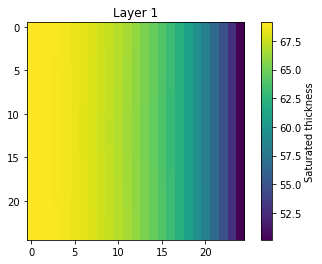

In [9]:
st = get_saturated_thickness(hds, m, nodata=-9999)

plt.imshow(st[0])
plt.colorbar(label='Saturated thickness')
plt.title('Layer 1')

### Get the water table
`get_water_table()` returns an nrow, ncol array of the water table elevation.  
This method can be useful when HDRY is turned on and the water table is in multiple layers.

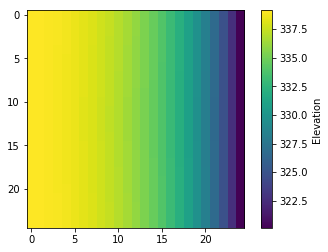

In [10]:
wt = get_water_table(heads=hds, nodata=-9999)

plt.imshow(wt)
plt.colorbar(label='Elevation')

### Get layer transmissivities at arbitrary locations, accounting for the position of the water table
* for this method, the heads input is an nlay x nobs array of head results, which could be constructed using the Hydmod package with an observation in each layer at each observation location, for example . 
* x, y values in real-world coordinates can be used in lieu of row, column, provided a correct `SpatialReference` object is attached to the flopy model object . 
* open interval tops and bottoms can be supplied at each location for computing transmissivity-weighted average heads 
* this method can also be used for apportioning boundary fluxes for an inset from a 2-D regional model  
* see `**flopy3_get_transmissivities_example.ipynb**` for more details on how this method works

In [11]:
r=[20, 5] 
c=[5, 20]
headresults = hds[:, r, c]
get_transmissivities(headresults, m, r=r, c=c)

array([[  3.42867432e+03,   2.91529083e+03],
       [  2.50000000e+03,   2.50000000e+03],
       [  1.99999996e-01,   1.99999996e-01],
       [  2.00000000e+04,   2.00000000e+04],
       [  2.00000000e+04,   2.00000000e+04]])

In [12]:
r=[20, 5] 
c=[5, 20]
sctop = [340, 320] # top of open interval at each location
scbot = [210, 150] # top of bottom interval at each location
headresults = hds[:, r, c]
tr = get_transmissivities(headresults, m, r=r, c=c, 
                          sctop=sctop, scbot=scbot)
tr

array([[  3.42867432e+03,   2.50000000e+03],
       [  2.50000000e+03,   2.50000000e+03],
       [  9.99999978e-02,   1.99999996e-01],
       [  0.00000000e+00,   1.00000000e+04],
       [  0.00000000e+00,   0.00000000e+00]])

#### convert to transmissivity fractions

In [13]:
trfrac = tr/tr.sum(axis=0)
trfrac

array([[  5.78310817e-01,   1.66664444e-01],
       [  4.21672316e-01,   1.66664444e-01],
       [  1.68668923e-05,   1.33331553e-05],
       [  0.00000000e+00,   6.66657778e-01],
       [  0.00000000e+00,   0.00000000e+00]])

#### Layer 3 contributes almost no transmissivity because of its K-value

In [14]:
m.lpf.hk.array[:, r, c]

array([[  5.00000000e+01,   5.00000000e+01],
       [  5.00000000e+01,   5.00000000e+01],
       [  9.99999978e-03,   9.99999978e-03],
       [  2.00000000e+02,   2.00000000e+02],
       [  2.00000000e+02,   2.00000000e+02]], dtype=float32)

In [15]:
m.dis.thickness.array[:, r, c]

array([[ 130.,  130.],
       [  50.,   50.],
       [  20.,   20.],
       [ 100.,  100.],
       [ 100.,  100.]], dtype=float32)